In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sun Apr  7 21:07:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:03:00.0 Off |                  N/A |
| 30%   28C    P8              23W / 350W |      5MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_labels(base_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(base_path):
        filepath = os.path.join(base_path, filename)
        if filepath.endswith(".png") and not "_mask" in filepath:
            images.append(filepath)
            labels.append(class_label)
    return images, labels

# Load benign and malignant images and masks
benign_images, benign_labels = load_images_and_labels("./Dataset_BUSI_with_GT/benign/", 0)
malignant_images, malignant_labels  = load_images_and_labels("./Dataset_BUSI_with_GT/malignant/", 1)

# Combine benign and malignant images and masks
images = benign_images + malignant_images
labels = benign_labels + malignant_labels

# Split the dataset into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, labels, img_width, img_height, is_augment=True):
        self.images = images
        self.labels = labels
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        mask = Image.open(self.images[index][:-4] + "_mask.png").resize((self.img_width, self.img_height))
        mask = np.array(mask, dtype=np.float32)
        label = torch.from_numpy(np.array(self.labels))[index].type(torch.LongTensor)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
                mask = cv2.warpAffine(mask, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)
                mask = cv2.flip(mask, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])
        
        y_transform = transforms.Compose([
            ToLabel(),
        ])

        img_new = tfms(img_new)
        mask = y_transform(mask)

        return img_new, label, mask

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, labels_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, labels_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))



Training samples #:  517
Test samples #:  130


In [6]:
class MultiVGG16(nn.Module):
    def __init__(self, n_classes):
        super(MultiVGG16, self).__init__()

        # Load a pretrained ResNet50 model
        vgg16 = models.vgg16(pretrained=True)
        # vgg16 = models.vgg16(pretrained=True).features
        self.pool = vgg16.avgpool
        num_features = vgg16.classifier[0].in_features 
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2)  # Change the out_features to 2 for binary classification
        )

        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = nn.Sequential(*(list(vgg16.features.children())[0:5]))
        self.enc_features2 = nn.Sequential(*(list(vgg16.features.children())[5:10]))
        self.enc_features3 = nn.Sequential(*(list(vgg16.features.children())[10:17]))
        self.enc_features4 = nn.Sequential(*(list(vgg16.features.children())[17:24]))
        self.enc_features5 = nn.Sequential(*(list(vgg16.features.children())[24:]))

        # Decoder
        self.upconv3 = self._make_up_block(512, 512)
        self.dec3 = self._make_dec_block(1024, 512)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(512, 256)
        self.dec2 = self._make_dec_block(512, 256)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(256, 128)
        self.dec1 = self._make_dec_block(256, 128)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(128, 64)
        self.dec0 = self._make_dec_block(128, 64)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(64, 64)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x)  # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        
        # Segmentation
   
        # Decoder with skip connections
        x = self.upconv3(x5)
        x = self.dec3(torch.cat([x, x4], dim=1))  # Use skip connection from layer3

        x = self.upconv2(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2

        x = self.upconv1(x)
        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1

        x = self.upconv0(x)
        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1

        x = self.upconv_final(x)
        
        # Classification
        
        cls = self.pool(x5)
        cls = cls.view(cls.size(0), -1)
        cls = self.classifier(cls)
        
        return cls, self.final_conv(x)

model = MultiVGG16(2)
model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# loss
loss_function = torch.nn.CrossEntropyLoss()


/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Train the model
epoch_training_loss = []
epoch_test_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for epoch in range(100):
    model.train()
    train_loss = []
    for batch_idx, (image, cls_label, seg_label) in enumerate(train_loader):
        image, cls_label, seg_label = image.to(device), cls_label.to(device), seg_label.to(device)
        optimizer.zero_grad()

        # Forward pass
        output_cls, output_seg = model(image)

        # Calculate loss
        loss1 = loss_function(output_seg, seg_label)
        loss2 = loss_function(output_cls, cls_label)
        
        loss = loss1 + 0.1 * loss2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print(f'Epoch {epoch+1}, Train loss: {np.mean(train_loss)}')
    epoch_training_loss.append(np.mean(train_loss))
    scheduler.step()

    # Evaluate on test data
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, cls_label, seg_label in test_loader:
            image, cls_label, seg_label = image.to(device), cls_label.to(device), seg_label.to(device)
            y_predict_cls, y_predict_seg = model(image)
            loss1 = loss_function(y_predict_seg, seg_label)
            loss2 = loss_function(y_predict_cls, cls_label)
            loss = loss1 + 0.1 * loss2
            test_loss.append(loss.item())
    print(f'Epoch {epoch+1}, Test loss: {np.mean(test_loss)}')
    epoch_test_loss.append(np.mean(test_loss))


# Draw curves here

import matplotlib.pyplot as plt

plt.plot(epoch_training_loss)

plt.plot(epoch_test_loss)
torch.save(model, "./save_models/VGG16_Multi.pt")

Epoch 1, Train loss: 0.7869287530581156
Epoch 1, Test loss: 0.6908043490515815
Epoch 2, Train loss: 0.5282646146687594
Epoch 2, Test loss: 0.49510201811790466
Epoch 3, Train loss: 0.43869139931418677
Epoch 3, Test loss: 0.40878669420878094
Epoch 4, Train loss: 0.3686367995811231
Epoch 4, Test loss: 0.3645315534538693
Epoch 5, Train loss: 0.33486590602181177
Epoch 5, Test loss: 0.32264431317647296
Epoch 6, Train loss: 0.29891583729874005
Epoch 6, Test loss: 0.2839855021900601
Epoch 7, Train loss: 0.2821023121024623
Epoch 7, Test loss: 0.2671821465094884
Epoch 8, Train loss: 0.26111603912078973
Epoch 8, Test loss: 0.2585596243540446
Epoch 9, Train loss: 0.24046552181243896
Epoch 9, Test loss: 0.28667038513554466
Epoch 10, Train loss: 0.2230746750578736
Epoch 10, Test loss: 0.2364640103446113
Epoch 11, Train loss: 0.21030767532912167
Epoch 11, Test loss: 0.2157759600215488
Epoch 12, Train loss: 0.19558417706778555
Epoch 12, Test loss: 0.25856150686740875
Epoch 13, Train loss: 0.1867608206

./Dataset_BUSI_with_GT/malignant/malignant (30).png


/tmp/ipykernel_786530/2448423239.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)


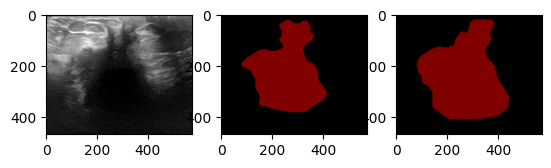

0.7320127602707247
0.875820257488439
./Dataset_BUSI_with_GT/benign/benign (110).png


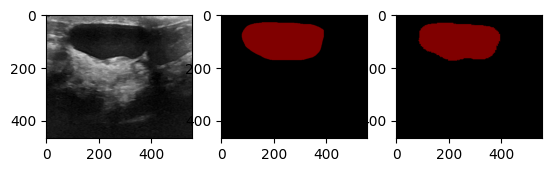

0.9206871345029239
0.98646613861739
./Dataset_BUSI_with_GT/benign/benign (245).png


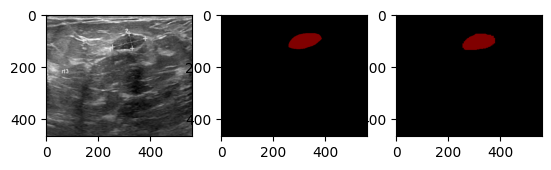

0.8186933416692717
0.9954538685227424
./Dataset_BUSI_with_GT/benign/benign (22).png


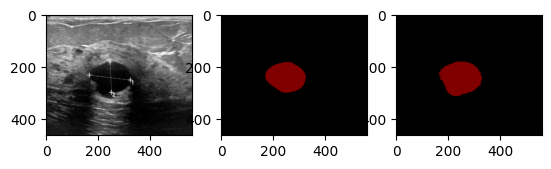

0.8489661185849526
0.9901652641184224
./Dataset_BUSI_with_GT/benign/benign (399).png


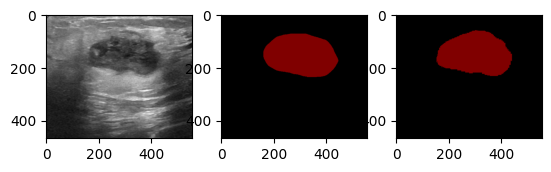

0.8976617384921883
0.9826870543158194
./Dataset_BUSI_with_GT/malignant/malignant (133).png


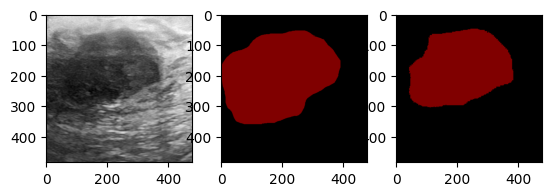

0.7318971820687328
0.8575033033787137
./Dataset_BUSI_with_GT/benign/benign (219).png


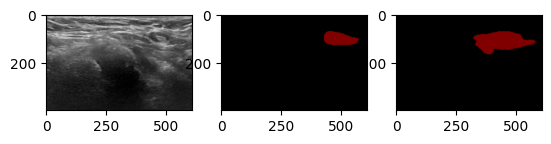

0.35700934579439253
0.9575902631053144
./Dataset_BUSI_with_GT/benign/benign (427).png


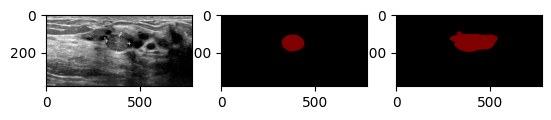

0.45008
0.9641930678112661
./Dataset_BUSI_with_GT/benign/benign (381).png


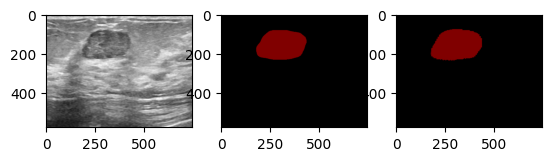

0.9299514045276757
0.9940735243978259
./Dataset_BUSI_with_GT/benign/benign (55).png


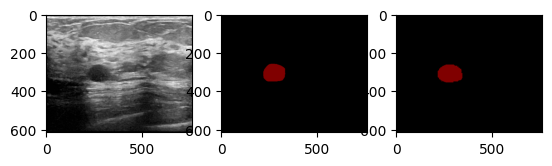

0.8539757611587349
0.9967769646488261
./Dataset_BUSI_with_GT/malignant/malignant (1).png


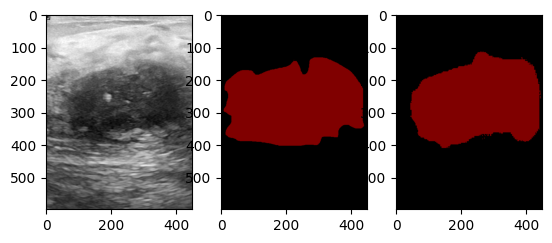

0.7838342843365748
0.8870303870303871
./Dataset_BUSI_with_GT/benign/benign (362).png


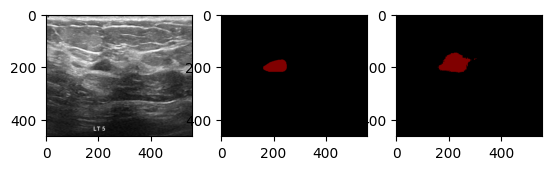

0.49737051792828685
0.987647213181528
./Dataset_BUSI_with_GT/benign/benign (15).png


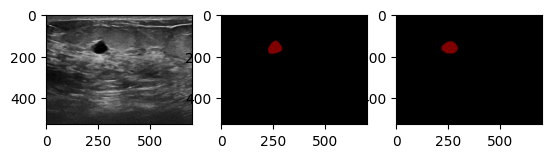

0.791451129866594
0.997906068301537
./Dataset_BUSI_with_GT/benign/benign (14).png


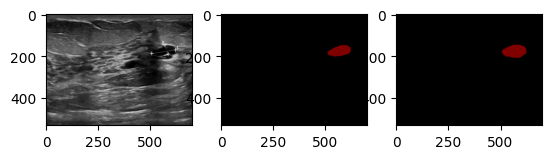

0.7618797124320533
0.9962979521514405
./Dataset_BUSI_with_GT/malignant/malignant (62).png


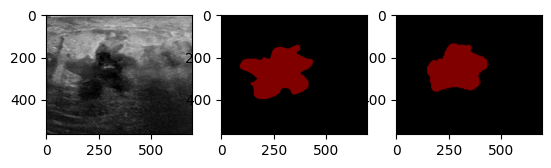

0.7289097059588863
0.9552910075616476
./Dataset_BUSI_with_GT/benign/benign (435).png


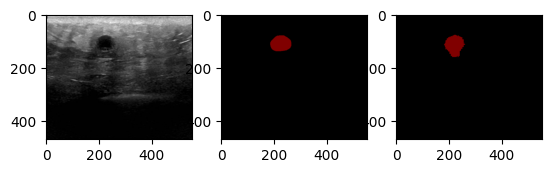

0.712893864013267
0.994578174116947
./Dataset_BUSI_with_GT/benign/benign (191).png


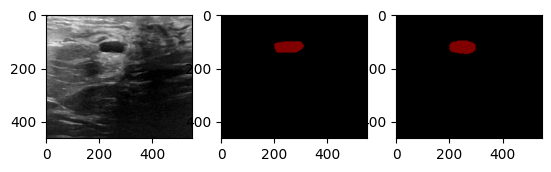

0.8080052782054101
0.996515150910332
./Dataset_BUSI_with_GT/malignant/malignant (145).png


0.8569071192833569
0.9975765076956861
./Dataset_BUSI_with_GT/benign/benign (335).png


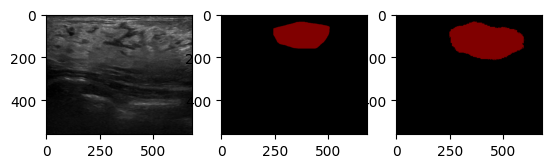

0.5124648427512145
0.9358407079646017
./Dataset_BUSI_with_GT/benign/benign (259).png


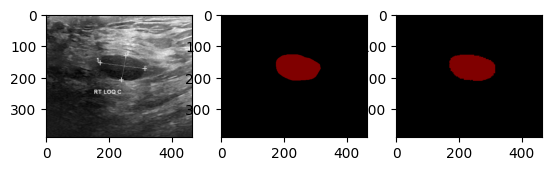

0.9276780310671777
0.995835100172521
./Dataset_BUSI_with_GT/benign/benign (45).png


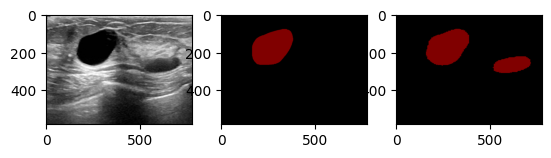

0.6705949231475611
0.9640282788441106
./Dataset_BUSI_with_GT/benign/benign (344).png


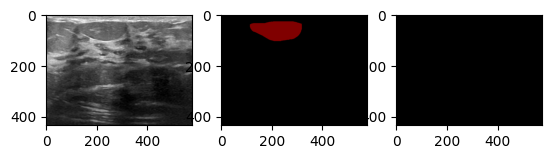

0.0
0.9511048707117256
./Dataset_BUSI_with_GT/benign/benign (199).png


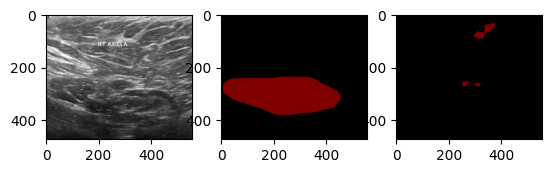

0.012589537660082483
0.809266247379455
./Dataset_BUSI_with_GT/benign/benign (240).png


0.7509265352776142
0.9701999104878413
./Dataset_BUSI_with_GT/malignant/malignant (140).png


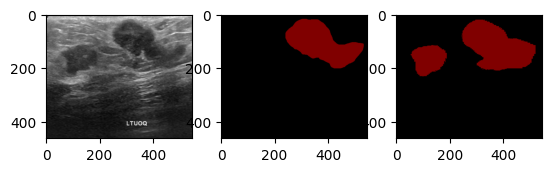

0.5988070708166142
0.9178604733780363
./Dataset_BUSI_with_GT/benign/benign (385).png


0.888855116514691
0.9954964386148573
./Dataset_BUSI_with_GT/benign/benign (125).png


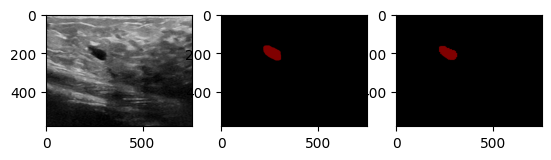

0.8576735092864125
0.9983170781888248
./Dataset_BUSI_with_GT/benign/benign (72).png


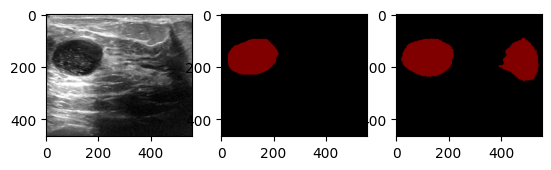

0.5168825869631746
0.9206490824631289
./Dataset_BUSI_with_GT/malignant/malignant (56).png


0.7282879744192429
0.926581339867174
./Dataset_BUSI_with_GT/benign/benign (196).png


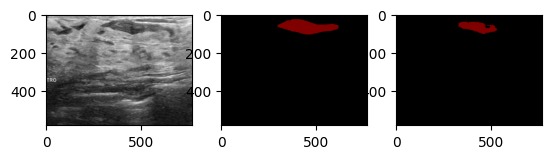

0.5092695709138553
0.9828387238663386
./Dataset_BUSI_with_GT/malignant/malignant (120).png


0.8725194916159351
0.9733848273893673
./Dataset_BUSI_with_GT/benign/benign (346).png


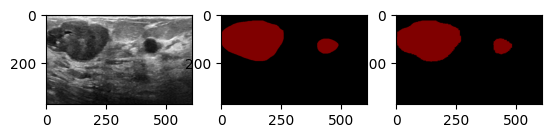

0.9299815007222321
0.9855212962186636
./Dataset_BUSI_with_GT/benign/benign (139).png


0.9139180862631389
0.9962509569925572
./Dataset_BUSI_with_GT/malignant/malignant (59).png


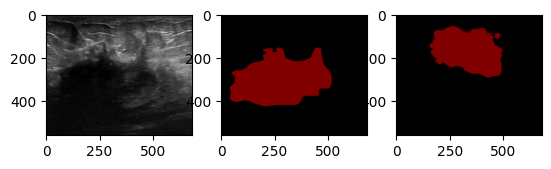

0.1773456736364572
0.7115313074330515
./Dataset_BUSI_with_GT/malignant/malignant (8).png


0.7894229223597492
0.9863311003985893
./Dataset_BUSI_with_GT/benign/benign (319).png


0.923576276187666
0.9969182564550034
./Dataset_BUSI_with_GT/benign/benign (303).png


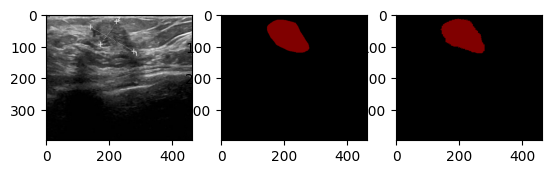

0.8816081956122548
0.9930060747236685
./Dataset_BUSI_with_GT/benign/benign (434).png


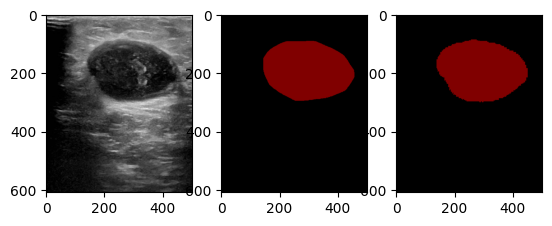

0.9362039003668662
0.9871250823191997
./Dataset_BUSI_with_GT/benign/benign (28).png


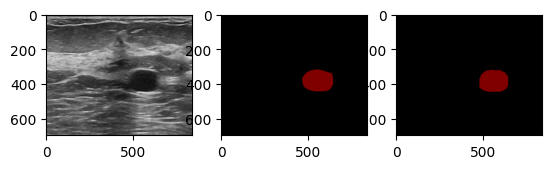

0.9021620780836833
0.9966774425287356
./Dataset_BUSI_with_GT/benign/benign (294).png


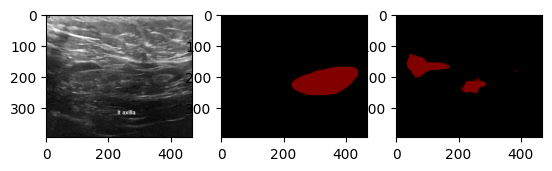

0.08586917608551117
0.9023849443221723
./Dataset_BUSI_with_GT/benign/benign (122).png


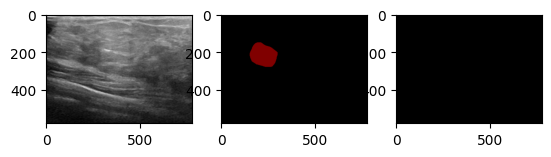

0.0
0.9682510893465712
./Dataset_BUSI_with_GT/benign/benign (129).png


0.8913548012764723
0.9983310307945987
./Dataset_BUSI_with_GT/malignant/malignant (181).png


0.0
0.948238611999868
./Dataset_BUSI_with_GT/benign/benign (171).png


0.0
0.9947759656259302
./Dataset_BUSI_with_GT/malignant/malignant (89).png


0.8242229100106496
0.9414350857253739
./Dataset_BUSI_with_GT/benign/benign (395).png


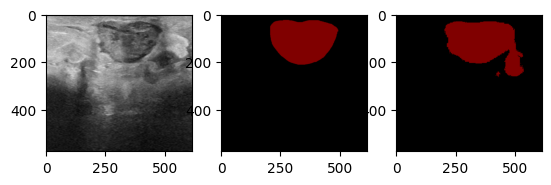

0.7691337421408058
0.962184326377521
./Dataset_BUSI_with_GT/malignant/malignant (44).png


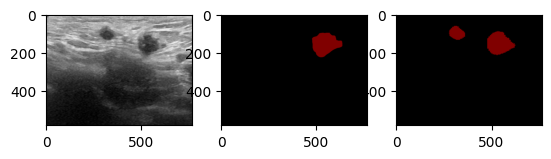

0.62840008567145
0.9839338463390468
./Dataset_BUSI_with_GT/benign/benign (264).png


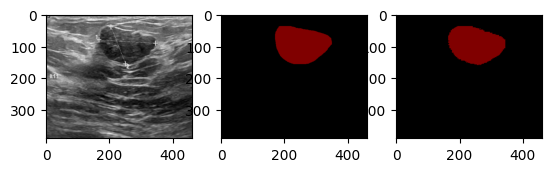

0.9173485606640372
0.9914939506479501
./Dataset_BUSI_with_GT/benign/benign (33).png


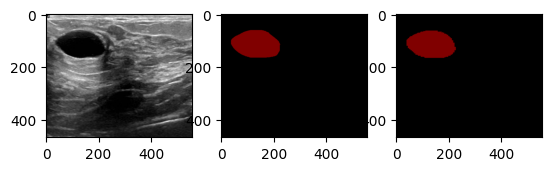

0.9538169147925245
0.9970263346821564
./Dataset_BUSI_with_GT/benign/benign (44).png


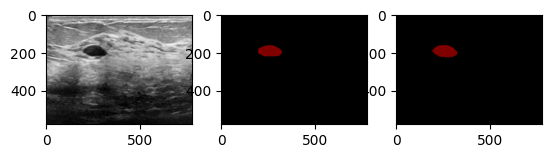

0.893562490577416
0.9984125306644661
./Dataset_BUSI_with_GT/malignant/malignant (138).png


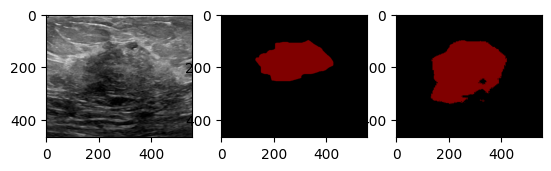

0.5996554387215588
0.9118585691241226
./Dataset_BUSI_with_GT/benign/benign (180).png


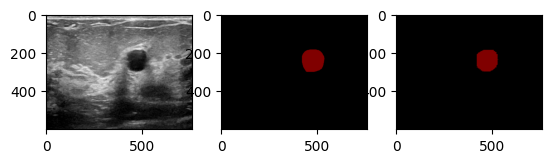

0.8925872463275877
0.9971718445386417
./Dataset_BUSI_with_GT/malignant/malignant (54).png


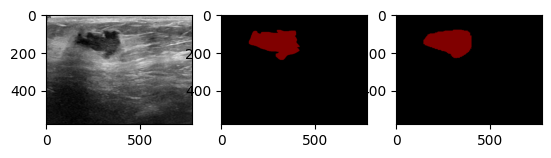

0.866311074640134
0.9908069866901155
./Dataset_BUSI_with_GT/malignant/malignant (203).png


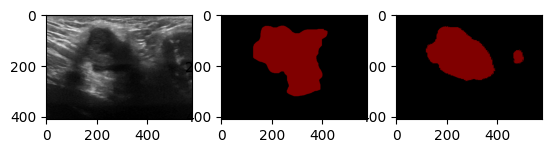

0.645700539078825
0.8993038053649407
./Dataset_BUSI_with_GT/benign/benign (239).png


0.8388289220760018
0.9957948666509778
./Dataset_BUSI_with_GT/benign/benign (23).png


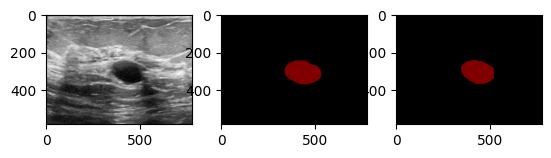

0.8861852433281004
0.9950254104322289
./Dataset_BUSI_with_GT/benign/benign (398).png


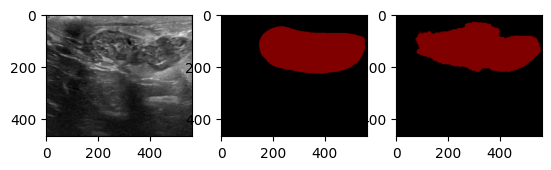

0.7613704786101362
0.9234270957526519
./Dataset_BUSI_with_GT/benign/benign (277).png


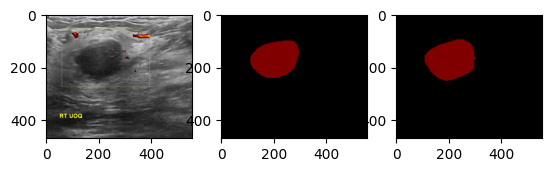

0.8876835560259294
0.9894154608243224
./Dataset_BUSI_with_GT/benign/benign (235).png


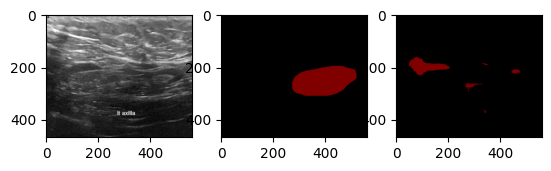

0.03323672915367402
0.899097919394733
./Dataset_BUSI_with_GT/benign/benign (334).png


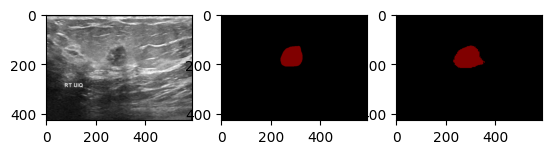

0.7500313243954392
0.9918547491507709
./Dataset_BUSI_with_GT/benign/benign (217).png


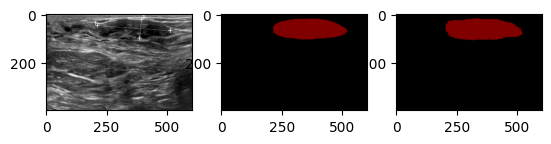

0.8887781197173942
0.9882446182249648
./Dataset_BUSI_with_GT/malignant/malignant (52).png


0.7179034372269152
0.928127797542569
./Dataset_BUSI_with_GT/benign/benign (365).png


0.8840343946084127
0.9958969551954086
./Dataset_BUSI_with_GT/benign/benign (409).png


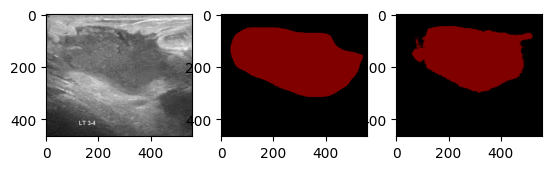

0.724322230059308
0.851697066541255
./Dataset_BUSI_with_GT/benign/benign (273).png


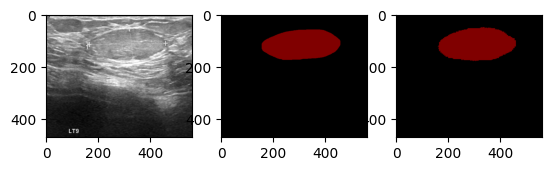

0.916122925048176
0.9894668466770258
./Dataset_BUSI_with_GT/benign/benign (153).png


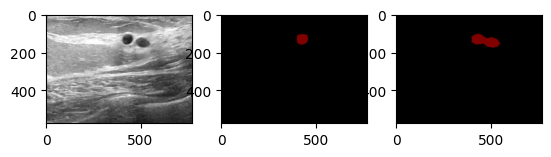

0.3912980420594634
0.9904706763844425
./Dataset_BUSI_with_GT/benign/benign (400).png


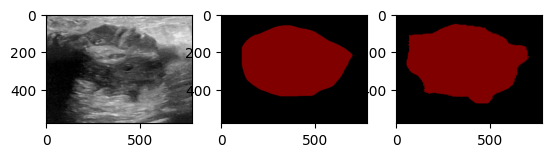

0.8583142216610405
0.9036305064901832
./Dataset_BUSI_with_GT/malignant/malignant (33).png


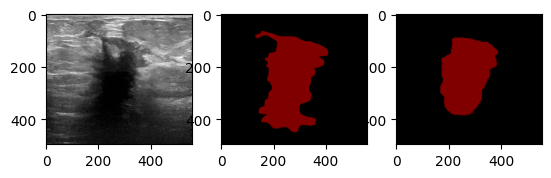

0.7213379875744572
0.9247349960860295
./Dataset_BUSI_with_GT/benign/benign (369).png


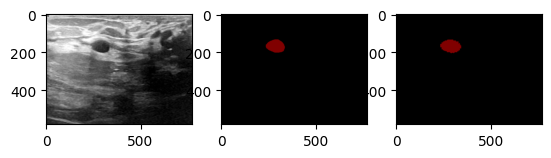

0.8852486559139785
0.9984591540462434
./Dataset_BUSI_with_GT/malignant/malignant (24).png


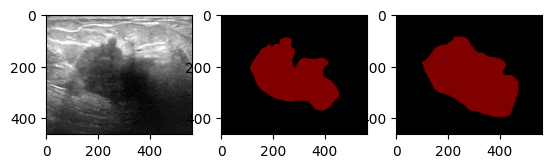

0.7689129406527364
0.9190879554986191
./Dataset_BUSI_with_GT/benign/benign (160).png


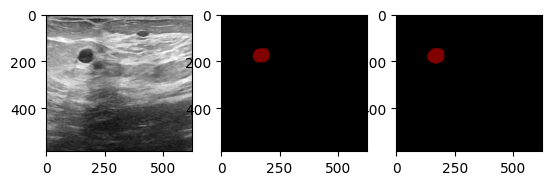

0.891146225232004
0.998799403574679
./Dataset_BUSI_with_GT/benign/benign (35).png


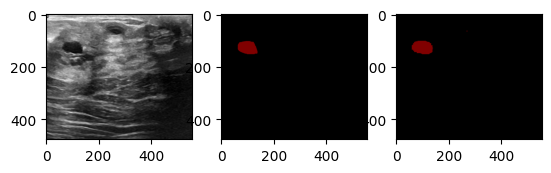

0.8782201405152225
0.9984101262726633
./Dataset_BUSI_with_GT/benign/benign (187).png


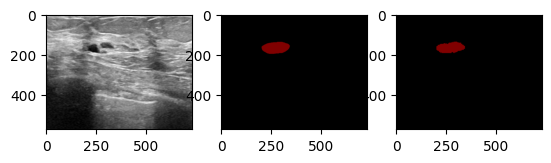

0.8750927162142116
0.9979618562116184
./Dataset_BUSI_with_GT/malignant/malignant (172).png


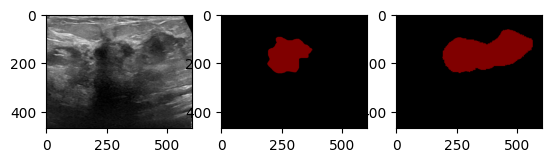

0.40794307233786936
0.9031815657338457
./Dataset_BUSI_with_GT/benign/benign (284).png


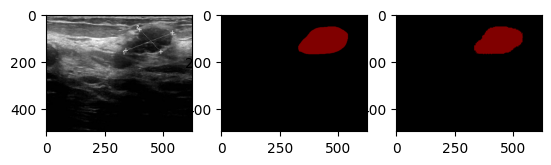

0.9296281076638586
0.9952926785689743
./Dataset_BUSI_with_GT/benign/benign (37).png


0.7712847450207923
0.9959362555998009
./Dataset_BUSI_with_GT/benign/benign (241).png


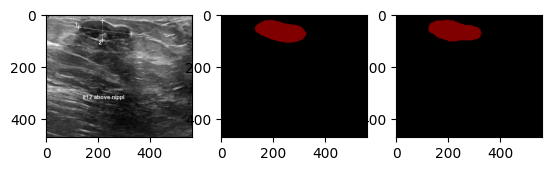

0.8757988757988758
0.9936327606896987
./Dataset_BUSI_with_GT/benign/benign (324).png


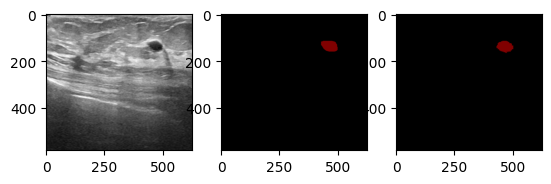

0.8144260074500508
0.998488496854253
./Dataset_BUSI_with_GT/benign/benign (7).png


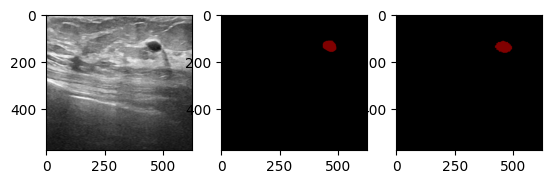

0.7249202410492733
0.9978361919208537
./Dataset_BUSI_with_GT/malignant/malignant (36).png


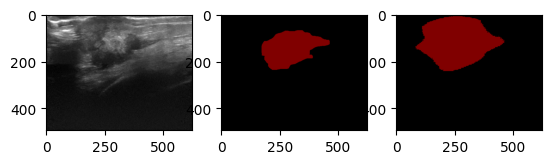

0.5257697632441337
0.9025741647465437
./Dataset_BUSI_with_GT/benign/benign (169).png


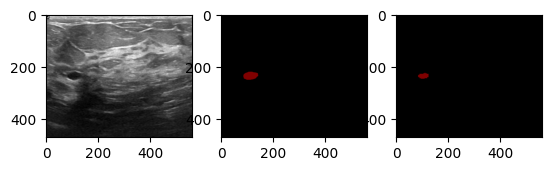

0.4804270462633452
0.9972183482323175
./Dataset_BUSI_with_GT/malignant/malignant (64).png


0.329032542811746
0.8687277468676512
./Dataset_BUSI_with_GT/benign/benign (215).png


0.8219105113636364
0.9956947431225346
./Dataset_BUSI_with_GT/malignant/malignant (7).png


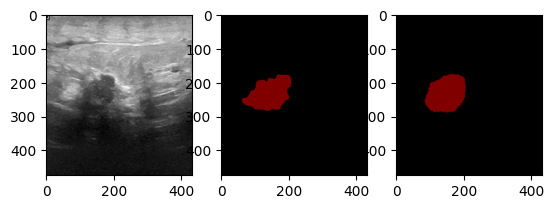

0.8070479993056159
0.9886274108558858
./Dataset_BUSI_with_GT/benign/benign (157).png


0.9048496009821977
0.9957171672515266
./Dataset_BUSI_with_GT/benign/benign (336).png


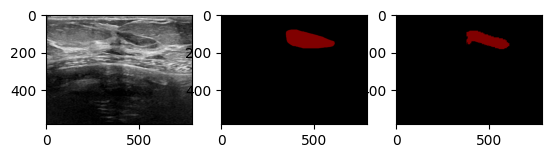

0.6466919016900358
0.9851387565173516
./Dataset_BUSI_with_GT/benign/benign (428).png


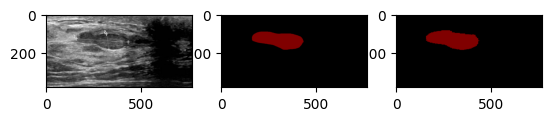

0.8906783548239131
0.9922361934545139
./Dataset_BUSI_with_GT/benign/benign (417).png


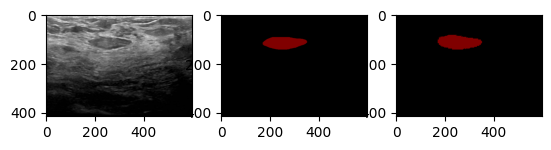

0.8416217540421362
0.9946639264092311
./Dataset_BUSI_with_GT/benign/benign (436).png


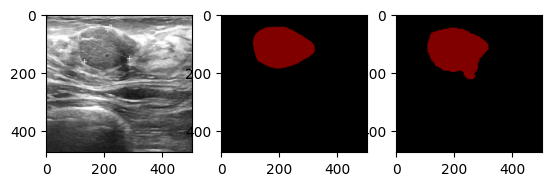

0.8204084708719572
0.9779531492857672
./Dataset_BUSI_with_GT/malignant/malignant (93).png


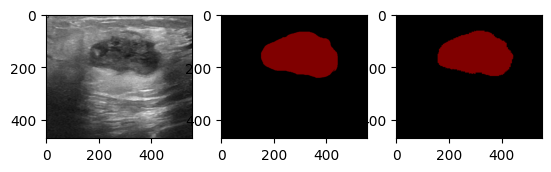

0.9320449367585828
0.9884557894549532
./Dataset_BUSI_with_GT/benign/benign (141).png


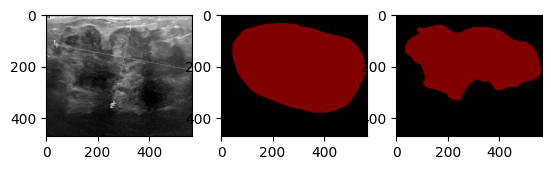

0.7336840886392914
0.7778884341916247
./Dataset_BUSI_with_GT/benign/benign (420).png


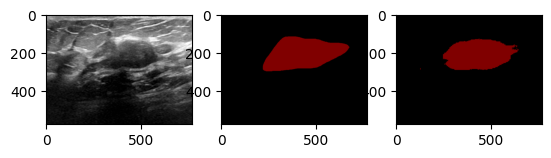

0.8003560395832242
0.9710386000091146
./Dataset_BUSI_with_GT/benign/benign (243).png


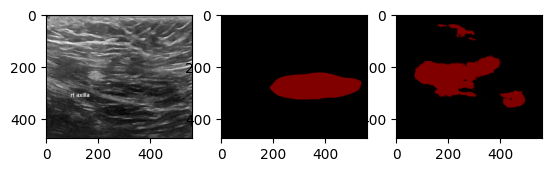

0.15318506265844406
0.8166162447972029
./Dataset_BUSI_with_GT/benign/benign (265).png


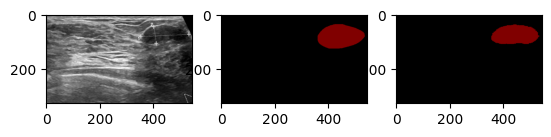

0.8008515424164524
0.9852846025536764
./Dataset_BUSI_with_GT/malignant/malignant (55).png


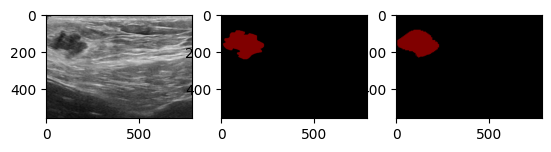

0.8435460558013228
0.9914495747527869
./Dataset_BUSI_with_GT/benign/benign (64).png


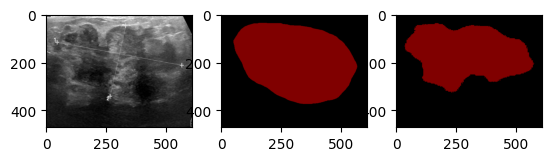

0.7407508058367491
0.8184658159867217
./Dataset_BUSI_with_GT/malignant/malignant (45).png


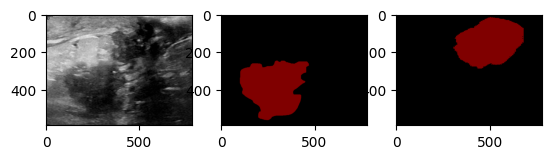

0.0137083935601191
0.6783164673013335
./Dataset_BUSI_with_GT/malignant/malignant (128).png


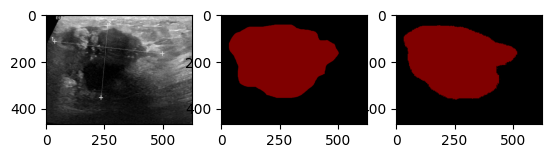

0.8753621146615714
0.9266906974094445
./Dataset_BUSI_with_GT/benign/benign (387).png


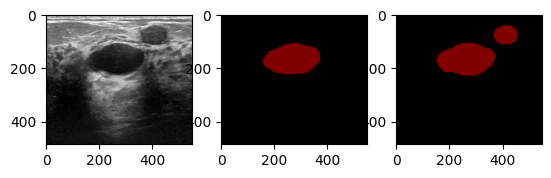

0.7382176520994002
0.9728839954652002
./Dataset_BUSI_with_GT/benign/benign (99).png


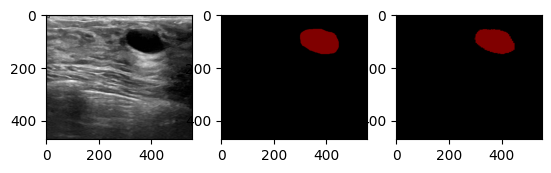

0.928729135388148
0.9967773882069181
./Dataset_BUSI_with_GT/malignant/malignant (28).png


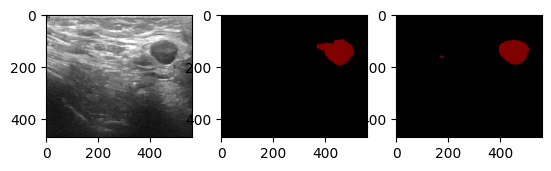

0.8512147925177381
0.9945984341703679
./Dataset_BUSI_with_GT/benign/benign (24).png


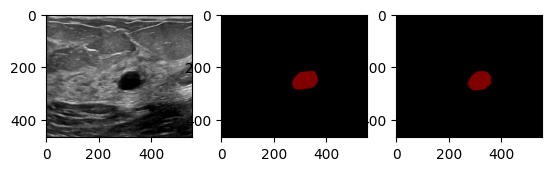

0.8625927234192865
0.9969462412861898
./Dataset_BUSI_with_GT/benign/benign (30).png


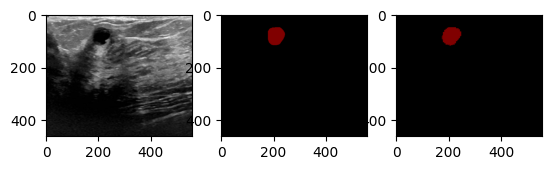

0.8914532082170936
0.9983137590172525
./Dataset_BUSI_with_GT/benign/benign (411).png


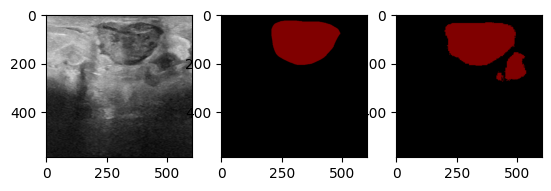

0.7674404820705325
0.962575906908721
./Dataset_BUSI_with_GT/benign/benign (402).png


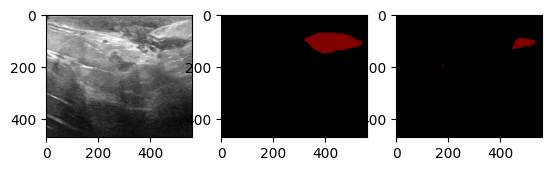

0.20165016501650165
0.9628795580534403
./Dataset_BUSI_with_GT/benign/benign (364).png


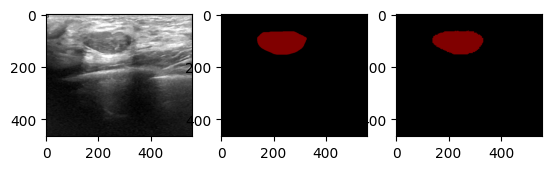

0.8867490056520829
0.9934103947672931
./Dataset_BUSI_with_GT/malignant/malignant (210).png


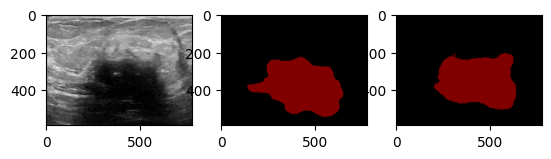

0.7457240291497405
0.9220735731761986
./Dataset_BUSI_with_GT/benign/benign (144).png


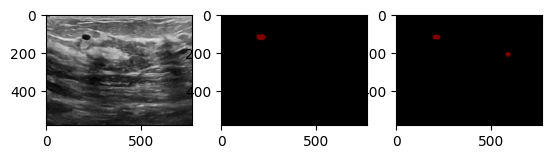

0.4963747908533185
0.9979740189809517
./Dataset_BUSI_with_GT/malignant/malignant (157).png


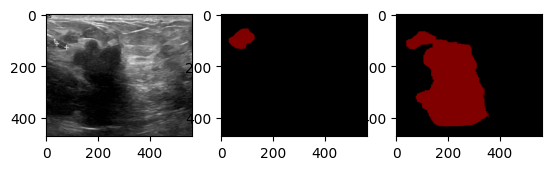

0.052503035462576585
0.7407572876333616
./Dataset_BUSI_with_GT/benign/benign (213).png


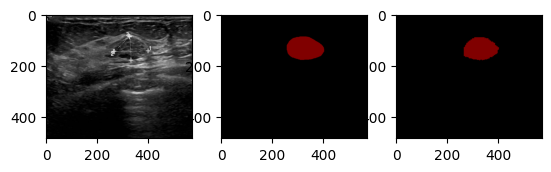

0.8755980861244019
0.9950732876330602
./Dataset_BUSI_with_GT/benign/benign (290).png


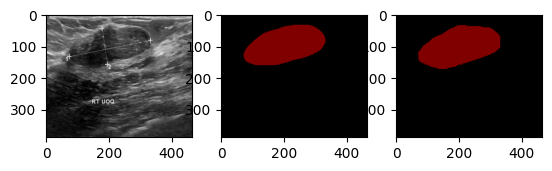

0.9013800589238642
0.9838612473276535
./Dataset_BUSI_with_GT/malignant/malignant (188).png


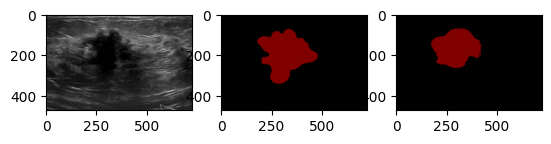

0.6310287234261913
0.9426196652867254
./Dataset_BUSI_with_GT/benign/benign (253).png


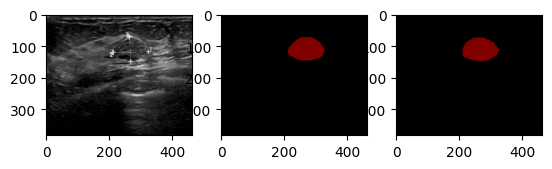

0.8817538896746817
0.9951138256524154
./Dataset_BUSI_with_GT/malignant/malignant (152).png


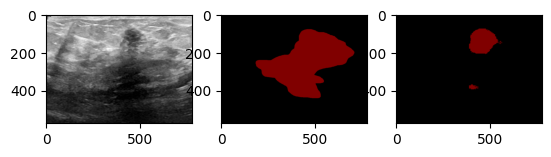

0.15352590724049178
0.8082271658628605
./Dataset_BUSI_with_GT/malignant/malignant (190).png


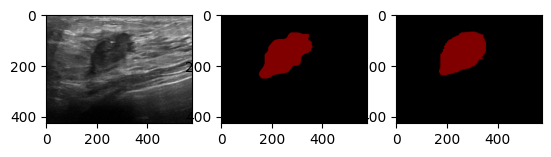

0.8444071679895262
0.9831212579833387
./Dataset_BUSI_with_GT/benign/benign (285).png


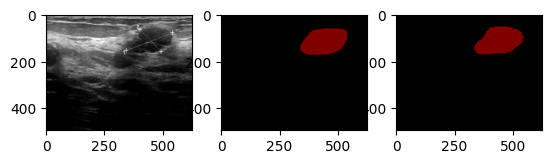

0.889169544821898
0.9926243820775915
./Dataset_BUSI_with_GT/benign/benign (108).png


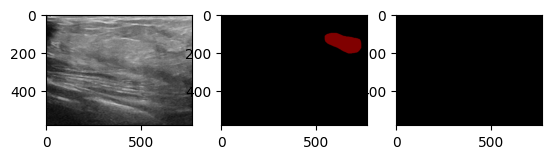

0.0
0.9690386497392517
./Dataset_BUSI_with_GT/benign/benign (173).png


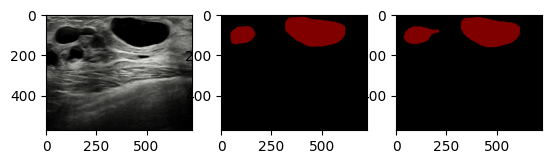

0.9190595230052023
0.990420827902737
./Dataset_BUSI_with_GT/benign/benign (432).png


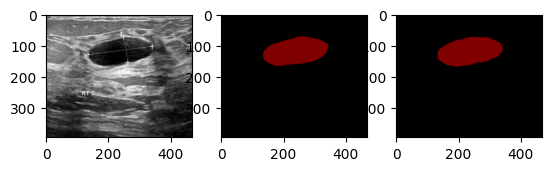

0.9389780827393245
0.9946335776344388
./Dataset_BUSI_with_GT/malignant/malignant (150).png


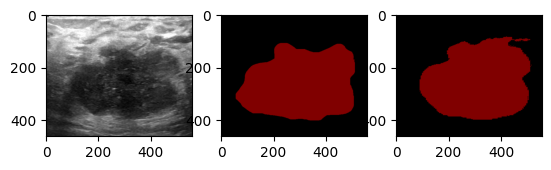

0.8599579947036801
0.9063261603865207
./Dataset_BUSI_with_GT/benign/benign (238).png


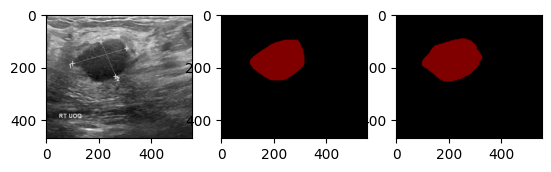

0.8741835029621753
0.9860649014700624
./Dataset_BUSI_with_GT/malignant/malignant (202).png


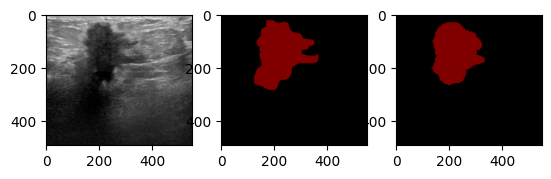

0.8144012220495668
0.9705304272188954
./Dataset_BUSI_with_GT/malignant/malignant (46).png


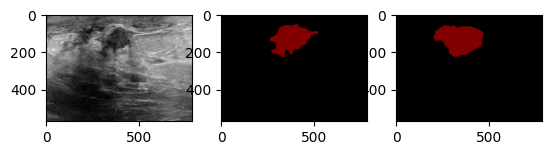

0.6461629105906613
0.9718250719561999
./Dataset_BUSI_with_GT/benign/benign (67).png


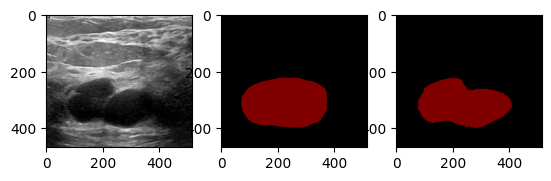

0.8091927963382812
0.9560842575773238
./Dataset_BUSI_with_GT/benign/benign (156).png


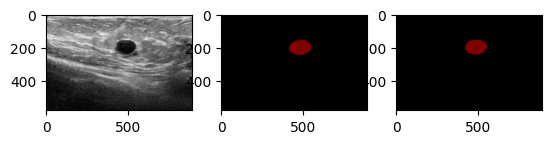

0.886290967226219
0.9977531062614887
./Dataset_BUSI_with_GT/malignant/malignant (148).png


0.7092662762659317
0.9966949786387541
./Dataset_BUSI_with_GT/benign/benign (220).png


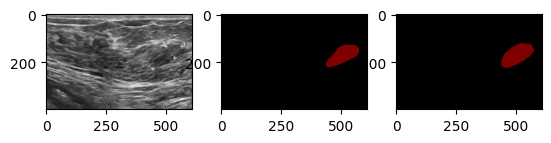

0.8243826818735467
0.9932140733102572
./Dataset_BUSI_with_GT/malignant/malignant (165).png


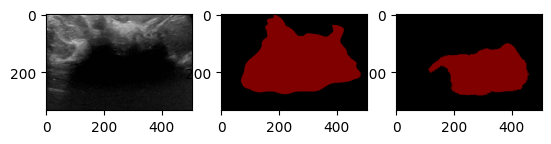

0.4910682965001754
0.712630368039737
./Dataset_BUSI_with_GT/benign/benign (76).png


0.9174450419850929
0.9984680192451799
./Dataset_BUSI_with_GT/malignant/malignant (131).png


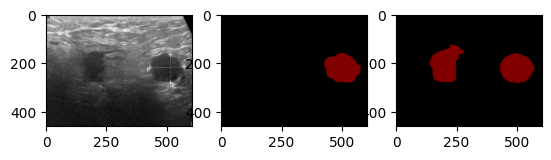

0.44773961492347836
0.9410680082936026
average tumor IoU: 0.7040965756666555
average background IoU: 0.9564250672821398


In [8]:
# Step 4: IoU and segmentation results
model = torch.load("./save_models/VGG16_Multi.pt")
model = model.to(device)
from utility import VOCPalette

total_tumor_IoU = []
total_background_IoU = []
palette = VOCPalette(nb_class=2)

for test_image in images_test:
    image = Image.open(test_image)
    print(test_image)
    label = Image.open(test_image[:-4] + "_mask.png")
    
    image_resize = image.convert("RGB").resize((224, 224))
    image_resize = np.array(image_resize)
    img_new = np.float32(image_resize)
    img_new = img_new /127.5 -1

  
    tfms = transforms.Compose([
            transforms.ToTensor()
        ])

    image_tensor = tfms(img_new).unsqueeze(0).to(device)

    predict = model(image_tensor)[1].squeeze(0)

    predict_label = torch.argmax(predict, 0)

    predict_label = predict_label.cpu().numpy().astype('uint8')

    # resize the predict result to original size
    
    PIL_predicr_pal_U = palette.genlabelpal(predict_label)
    PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(PIL_img_pal)
    plt.show()

    # Compute IoU between thresh1 and label

    def compute_iou(mask1, mask2):
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        return iou

    # IoU

    print(compute_iou(np.array(PIL_img_pal), np.array(label)))
    print(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
    total_tumor_IoU.append(compute_iou(np.array(PIL_img_pal), np.array(label)))
    total_background_IoU.append(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
print("average tumor IoU:", np.mean(total_tumor_IoU))
print("average background IoU:", np.mean(total_background_IoU))

In [7]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix
model = torch.load("./save_models/VGG16_Multi.pt")
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)
    
    true_labels = []
    probabilities = []
    predictions = []  # Correctly initialize the predictions list

    with torch.no_grad():  # Do not compute gradients
        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
            preds = (probs >= threshold).cpu().numpy().astype(int)  # Binary predictions based on the threshold
            
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            predictions.extend(preds)  # Add the predictions to the list

    # Convert lists to numpy arrays for consistency
    true_labels = np.array(true_labels)
    probabilities = np.array(probabilities)
    predictions = np.array(predictions)
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, probabilities)  # AUC using probabilities

    # Compute confusion matrix and extract TN, FP, FN, TP for calculating TPR and FPR
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    
    return accuracy, precision, f1, auc, tpr, fpr

# Assuming 'device' and 'test_loader' are already defined
# Evaluate the model and print the metrics
accuracy, precision, f1, auc, tpr, fpr = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nF1 Score: {f1}\nAUC: {auc}\nTPR: {tpr}\nFPR: {fpr}")


Accuracy: 0.9076923076923077
Precision: 0.8648648648648649
F1 Score: 0.8421052631578947
AUC: 0.9526627218934912
TPR: 0.8205128205128205
FPR: 0.054945054945054944
